We consider the following dynamics:
$$\begin{bmatrix}\dot x \\ \dot y \\ \dot \theta\end{bmatrix} = \begin{bmatrix}v\cos (\theta) \\ v\sin (\theta) \\ u\end{bmatrix},$$ 
with states $x, y, \theta$ and control $u$. $v$ is the uncertain parameter

In [125]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import numpy as np

import matplotlib
import pickle as pkl

from scipy.interpolate import interp1d
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

import hj_reachability as hj
# from parent repo import utils
import sys
sys.path.append('..') 
import utils
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
from cbf_opt import ControlAffineDynamics, BatchedDynamics, ControlAffineASIF
from experiment_wrapper import RolloutTrajectory, StateSpaceExperiment, TimeSeriesExperiment
from refine_cbfs import HJControlAffineDynamics, TabularControlAffineCBF

init_notebook_mode(connected=True)

In [ ]:
class Obstacle:
    def __init__(self, type, stateIndices) -> None:
        self.type = type
        self.stateIndices = stateIndices

class Rectangle(Obstacle):
    def __init__(self, stateIndices, minVal, maxVal) -> None:
        super().__init__("Rectangle", stateIndices)
        self.minVal = jnp.reshape(np.array(minVal), (-1, 1))
        self.maxVal = jnp.reshape(np.array(maxVal), (-1, 1))

    def obstacle_sdf(self, x):
        max_dist_per_dim = jnp.max(
            jnp.array(
                [
                    self.minVal -
                    jnp.reshape(x[..., self.stateIndices], (-1, 1)),
                    jnp.reshape(x[..., self.stateIndices],
                                (-1, 1)) - self.maxVal,
                ]
            ),
           axis=0,
        )

        def outside_obstacle(_):
            return jnp.linalg.norm(jnp.maximum(max_dist_per_dim, 0))

        def inside_obstacle(_):
            return jnp.max(max_dist_per_dim)

        obstacle_sdf = (
            jax.lax.cond(jnp.all(max_dist_per_dim < 0.0),
                         inside_obstacle, outside_obstacle, operand=None)
        )
        return obstacle_sdf

In [2]:
from numpy import ndarray


class Dubins(ControlAffineDynamics):
    STATES = ['X', 'Y', 'THETA']
    CONTROLS = ['OMEGA']

    def __init__(self, params, **kwargs):
        super().__init__(params, **kwargs)

    def open_loop_dynamics(self, state: ndarray, time: float = 0.0) -> ndarray:
        return jnp.array([self.params['v'] * jnp.cos(state[2]),
                          self.params['v'] * jnp.sin(state[2]),
                          0.0])
    
    def control_matrix(self, state, time: float = 0.0) -> ndarray:
        return jnp.array([[0.0], [0.0], [1.0]])

In [71]:
umax = 0.5
obstacle = Rectangle([0, 1], [4.0, -2.0], [6.0, 2.0])
target = jnp.array([[9.0, 4.0, 0.0]])
dyn = Dubins(params={'v': 1.0}, dt=0.01)
batched_dyn = BatchedDynamics(dyn)
dyn_hjr = HJControlAffineDynamics(dyn, control_space=hj.sets.Box(jnp.array([-umax]), jnp.array([umax])))
nominal_controller = lambda t: lambda x, time: jnp.clip(
    jnp.mod(jnp.arctan2(x[:,1] - t[:,1], x[:,0] - t[:,0]) - x[:,2], 2 * jnp.pi) - jnp.pi, -umax, umax)

In [109]:
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    domain=hj.sets.Box(lo=jnp.array([0.0, -5.0, -jnp.pi]), hi=jnp.array([10.0, 5.0, jnp.pi])),
    shape=(201, 201, 101),
    periodic_dims=2
)

visualization_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    domain=hj.sets.Box(lo=jnp.array([0.0, -5.0]), hi=jnp.array([10.0, 5.0])),
    shape=(201, 201),
)

In [110]:
sdf_values = hj.utils.multivmap(obstacle.obstacle_sdf, jnp.arange(grid.ndim))(grid.states)

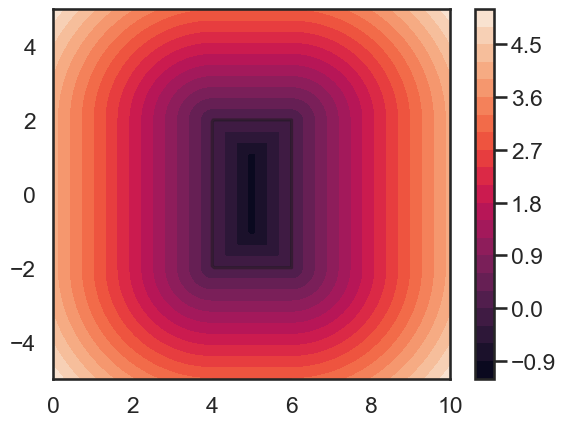

In [111]:
cf = plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], sdf_values[:,:,0].T, levels=20)
# add colorbar
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], sdf_values[:,:,0].T, levels=[0], colors='k', alpha=0.5)
plt.colorbar(cf)
hj.viz.visFunc(visualization_grid, sdf_values[:,:,0])  # toggle 
#hj.viz.visFunc(grid_dist, sdf_values_dist)

## Testing the nominal controller

In [112]:
x0s = jnp.array([[0.0, 0.0, jnp.pi / 4],
                 [0.0, 2.0, jnp.pi / 4],
                 [0.0, 4.0, -jnp.pi / 4],
                 [0.0, -2.0, -jnp.pi / 2],
                 [2.0, 0.0, -jnp.pi],
                 [6.0, 4.0, -jnp.pi]])
experiment = RolloutTrajectory('dubins', start_x=x0s, n_sims_per_start=1, t_sim=10.0)

In [113]:
results_df = experiment.run(batched_dyn, {"Nominal": nominal_controller(target)})

Controller rollout: 100%|██████████| 1000/1000 [00:10<00:00, 91.20it/s]


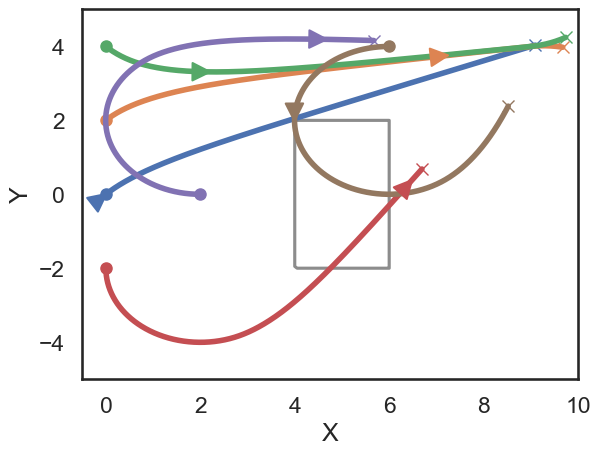

In [117]:
ss_exp = StateSpaceExperiment('dubins', x_indices=[0, 1], start_x=x0s)
fig, ax = plt.subplots()
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], sdf_values[:,:,0].T, levels=[0], 
            colors='k', alpha=0.5)
ss_exp.plot(batched_dyn, results_df, ax=ax);

## Reachability based work
First we will just do it offline

In [118]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(sdf_values))
times = jnp.linspace(0, -10.0, 51)

In [119]:
_, target_values = hj.solve(solver_settings, dyn_hjr, grid, times, sdf_values)

100%|##########| 10.0000/10.0 [02:29<00:00, 14.94s/sim_s]


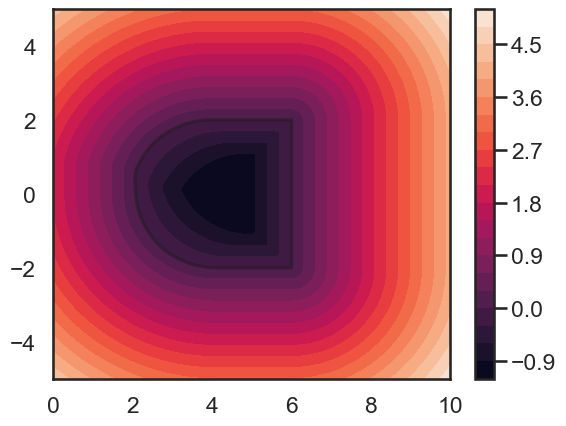

In [ ]:
cf = plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[-1][:,:,50].T, levels=20)
# add colorbar
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[-1][:,:,50].T, levels=[0], colors='k', alpha=0.5)
plt.colorbar(cf)
hj.viz.visFunc(visualization_grid, target_values[-1][:,:,50])  # toggle 
#hj.viz.visFunc(grid_dist, sdf_values_dist)

In [138]:
tabular_cbf = TabularControlAffineCBF(batched_dyn, grid=grid)
tabular_cbf.vf_table = np.array(target_values[-1])

In [160]:
x0 = jnp.array([2.0, -1.0, 0.0])
n_sims_per_start = 1
t_sim = 10.0
alpha = lambda x: 1.0 * x

In [161]:
dubins_asif = ControlAffineASIF(batched_dyn, tabular_cbf, alpha=lambda x: x, nominal_policy=nominal_controller(target),
                                umin=jnp.array([-umax]), umax=jnp.array([umax]), test=False)

In [162]:
experiment = RolloutTrajectory('dubins', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

In [163]:
import logging
logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)  # Surpresses warnings
results_df = experiment.run(batched_dyn, {'Nominal': nominal_controller(target), 'Analytical': dubins_asif})

Controller rollout: 100%|██████████| 1000/1000 [00:34<00:00, 28.82it/s]


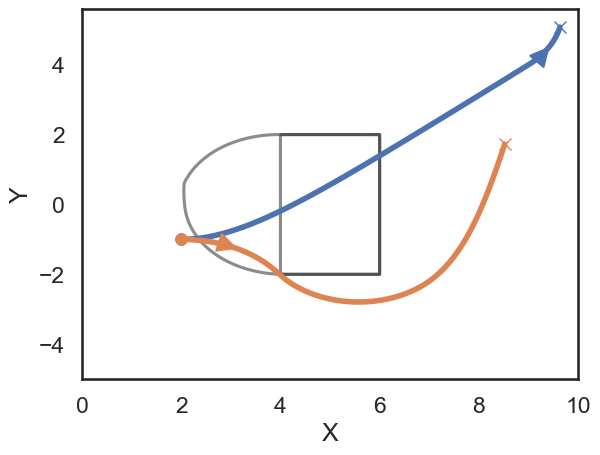

In [164]:
ss_exp = StateSpaceExperiment('quad', x_indices=[0, 1], start_x=x0)
fig, ax = plt.subplots()
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], sdf_values[:,:,0].T, levels=[0], 
            colors='k', alpha=0.5)
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[-1][:,:,50].T, levels=[0], colors='k', alpha=0.5)
ss_exp.plot(batched_dyn, results_df, ax=ax);